This notebook uses pyCFIT to analyse the performance of Astropy Modeling.

In [1]:
from pathlib import Path

import numpy as np
import astropy.units as u
import astropy.modeling.models as m
import matplotlib.pyplot as plt

from sunraster.instr.spice import read_spice_l2_fits
from sospice.calibrate import spice_error

from pyCFIT.fit import cfit_raster
from pyCFIT.function import Function, FunctionFitter

/home/stuart/.virtualenvs/spice-fitting/lib/python3.12/site-packages/setuptools_scm/_config.py:68: UserWarning: absolute root path '/home/stuart/Git/astropy/astropy' overrides relative_to '/home/stuart/Git/astropy/astropy/_dev/scm_version.py'
  warnings.warn(


In [2]:
%matplotlib widget

In [3]:
data_dir = Path('./data')
file = data_dir / 'solo_l2_spice_n_ras_20220403t121537_v07_100664022_000.fits'
window = 'Ly-gamma-CIII group (Merged)'

In [4]:
spice = read_spice_l2_fits(str(file))[window]
spice.mask |= (spice.data <= 0)
spice.data[spice.mask] = np.nan
include = ~np.all(spice.mask, axis=(0, 2, 3))

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59672.510847 from DATE-OBS.
Set MJD-BEG to 59672.510847 from DATE-BEG.
Set MJD-AVG to 59672.515708 from DATE-AVG.
Set MJD-END to 59672.520566 from DATE-END'. [astropy.wcs.wcs]


In [5]:
av_constant_noise_level, sigmadict = spice_error(data=spice.data, header=spice.meta)
sigma = sigmadict["Total"].value 
mask = spice.mask | np.isnan(sigma) | (sigma <= 0)

W / (nm sr m2)
Getting observation parameters from Ly-gamma-CIII group (Merged)

Slit: 4.0 arcsec
Bin: (1, 1)
Exposure time: 5.0 s
Window width: 64.0 pix
Average wavelength: 97.602232 nm
RADCAL: 30.9672782204 m2 ct nm sr / W
            


In [6]:
# Prep averaged data for CFIT call, remove masked values
wavelength = spice.axis_world_coords_values().em_wl.to_value(u.Angstrom)[include]
intensity = np.nanmean(spice.data, axis=(0, 2, 3))[include]
uncertainty = None  #TBD for averaged data

/tmp/ipykernel_446995/1389015179.py:3: RuntimeWarning: Mean of empty slice
  intensity = np.nanmean(spice.data, axis=(0, 2, 3))[include]


In [7]:
astromodel = m.Const1D() + m.Gaussian1D()
astromodel.mean_1 = 976.8 # Angstroms
astromodel.amplitude_1 = 4

modelFitter = FunctionFitter(wavelength, intensity, uncertainty=uncertainty, function=astromodel)

In [8]:
astromodel

<CompoundModel(amplitude_0=1., amplitude_1=4., mean_1=976.8, stddev_1=1.)>

In [9]:
modelFitter.fit()
fitted_model  = modelFitter.get_model()

In [10]:
n = 160
i = 400
j = 0
wavelength2 = spice.axis_world_coords_values().em_wl.to_value(u.Angstrom)
intensity2 = np.squeeze(spice.data[:, :, i:i+n, j:j+n])
uncertainty2 = np.squeeze(sigma[:, :, i:i+n, j:j+n])
mask2 = np.squeeze(mask[:, :, i:i+n, j:j+n])

With Astropy 6.1.2 the following example took 3m 51s

In [11]:
import astropy
print(astropy.__version__)

7.0.0.dev810+gb982985335


In [12]:
%%time

GM = cfit_raster(fitted_model, wavelength2, intensity2, uncertainty2, mask2)  

    The maximum number of function evaluations is exceeded. [astropy.modeling.fitting]


CPU times: user 1min 51s, sys: 31.1 ms, total: 1min 51s
Wall time: 1min 52s


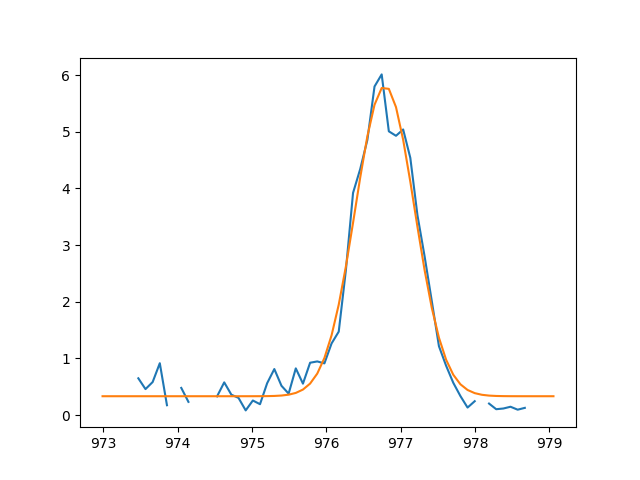

In [13]:
fig, ax = plt.subplots()
ax.plot(wavelength2, intensity2[:,0,5])
ax.plot(wavelength2, GM[0,5](wavelength2))
plt.show()

In [14]:
shift_from_initial = GM.amplitude_1.value - astromodel.amplitude_1

In [15]:
spice_mean = spice.rebin(bin_shape=(1, 64, 1, 1))[0,0]

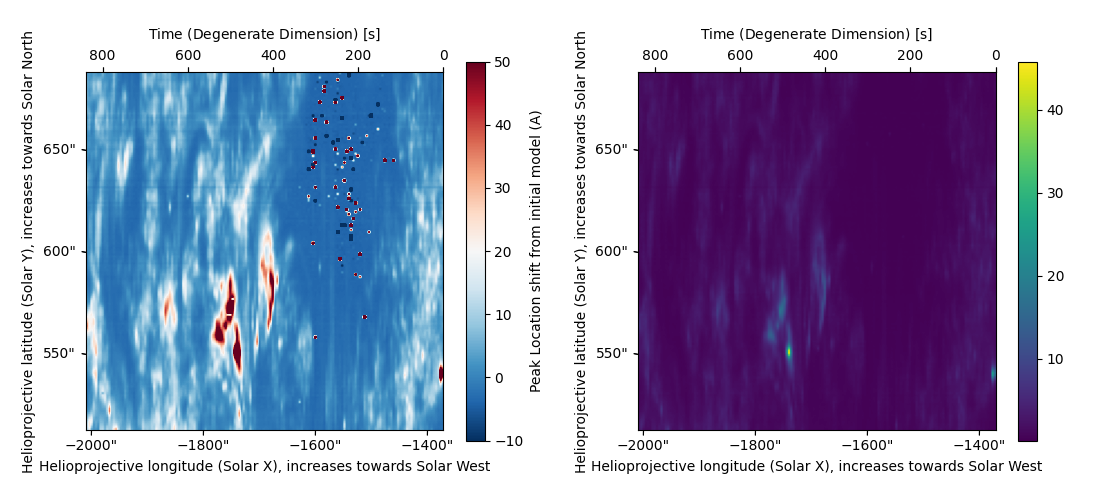

In [16]:
fig = plt.figure(figsize=(11, 5))
ax = plt.subplot(121, projection=spice[0,0,i:i+n,j:j+n].wcs)
im = ax.imshow(shift_from_initial, cmap="RdBu_r", origin="lower", vmin=-10, vmax=50)
plt.colorbar(im, label=f"Peak Location shift from initial model (A)")
ax = plt.subplot(122, projection=spice_mean.wcs)
spice_mean[i:i+n, j:j+n].plot(axes=ax)
plt.colorbar(ax=ax)
fig.tight_layout()